In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
# Paths
train_image_directory = 'D:\\ML\\d\\archive\\Emergency_Vehicles\\train'  # Path to training image folder

train_csv_file_path = 'D:\\ML\\d\\archive\\Emergency_Vehicles\\train.csv'  # Path to train CSV file

# Load CSV files for train and test
train_df = pd.read_csv(train_csv_file_path)


In [4]:
train_df

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0
...,...,...
1641,1638.jpg,0
1642,1095.jpg,0
1643,1130.jpg,0
1644,1294.jpg,0


In [5]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [6]:
train_df['emergency_or_not'] = train_df['emergency_or_not'].astype(str)
val_df['emergency_or_not'] = val_df['emergency_or_not'].astype(str)

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)


In [8]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_image_directory,   # folder where your images are stored
    x_col='image_names',          # column for image file names
    y_col='emergency_or_not',    # column for labels
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_image_directory,   # same folder for validation set
    x_col='image_names',
    y_col='emergency_or_not',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 1316 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.


In [41]:
from tensorflow.keras.layers import GlobalAveragePooling2D
# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential([
     base_model,
     GlobalAveragePooling2D(),  # Better alternative to Flatten for CNN models
     Dense(1024, activation='relu'),
     Dense(1, activation='sigmoid')
])

base_model.trainable = False  # Freeze the base model layers


In [42]:
from tensorflow.keras.optimizers import Adam

# Compile the model with updated learning rate argument
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [43]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True
)


In [47]:
history = model.fit(
    train_generator,
    epochs=2,
    validation_data=val_generator,
    callbacks=[checkpoint]
)


Epoch 1/2
42/42 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7392 - loss: 0.5545 - val_accuracy: 0.7030 - val_loss: 0.5996
Epoch 2/2
42/42 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.7298 - loss: 0.5396 - val_accuracy: 0.7455 - val_loss: 0.5443


In [46]:
model.save('best_model.keras')


In [16]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

In [24]:
import matplotlib.pyplot as plt

In [26]:
image_path = 'D:\\ML\\d\\archive\\h.png'  # Update this to your image file path

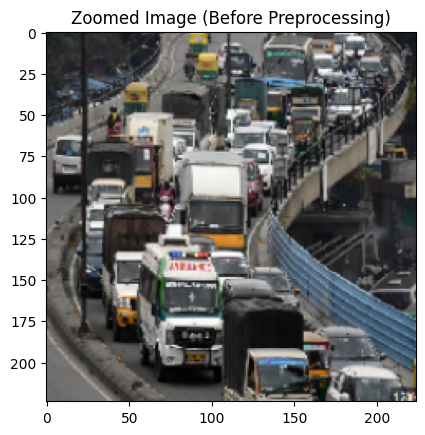

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Not Emergency Vehicle


In [37]:
# Create an ImageDataGenerator with zoom and rescale (but no other preprocessing)
datagen = ImageDataGenerator(
    zoom_range=0.2,      # Zooms the image randomly by 20%
    rescale=1./255       # Scale the pixel values between 0 and 1
)

def predict_image(image_path):
    # Load the image (no preprocessing yet)
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Apply zoom and scaling (no preprocessing yet)
    img_array_zoomed = datagen.flow(img_array, batch_size=1)[0]

    # Show the zoomed image (before preprocess_input)
    plt.imshow(img_array_zoomed[0])  # Display zoomed and scaled image
    plt.title('Zoomed Image (Before Preprocessing)')
    plt.show()

    # Preprocess for ResNet50 (only for prediction)
    img_array_preprocessed = preprocess_input(img_array_zoomed)

    # Predict the class
    prediction = model.predict(img_array_preprocessed)
    if prediction[0] > 0.5:
        return "Emergency Vehicle"
    else:
        return "Not Emergency Vehicle"

# Example usage
result = predict_image(image_path)
print(result)